# Setup

In [1]:
import yfinance as yf
import pandas as pd
import cufflinks as cf
import datetime
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# plt.style.use('seaborn')
# NOTE: rcParams need to be after style.use
plt.rcParams["figure.figsize"] = (22, 10)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
tickerSymbol = "FB"

In [4]:
tickerData = yf.Ticker(tickerSymbol)

In [5]:
# tickerData.info.keys()

In [6]:
tickerData.info['longName']

'Facebook, Inc.'

In [7]:
start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2021, 1, 31)
ticker_df = tickerData.history(period='1d', start=start_date, end=end_date)
print(len(ticker_df))
ticker_df.head()

20


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-12-31,272.000000,277.089996,269.809998,273.160004,12900400,0,0
2021-01-04,274.779999,275.000000,265.200012,268.940002,15106100,0,0
2021-01-05,268.290009,272.399994,268.209991,270.970001,9871600,0,0
2021-01-06,262.000000,267.750000,260.010010,263.309998,24354100,0,0
2021-01-07,265.899994,271.609985,264.779999,268.739990,15789800,0,0


In [8]:
# full_df = yf.download(tickerSymbol)
# display(full_df.tail())
# # Taking only the close price
# df = full_df[['Close']]

In [9]:
# df.to_csv('fb_close.csv')

In [23]:
orig_df = pd.read_csv('fb_close.csv', index_col=[0], parse_dates=[0])

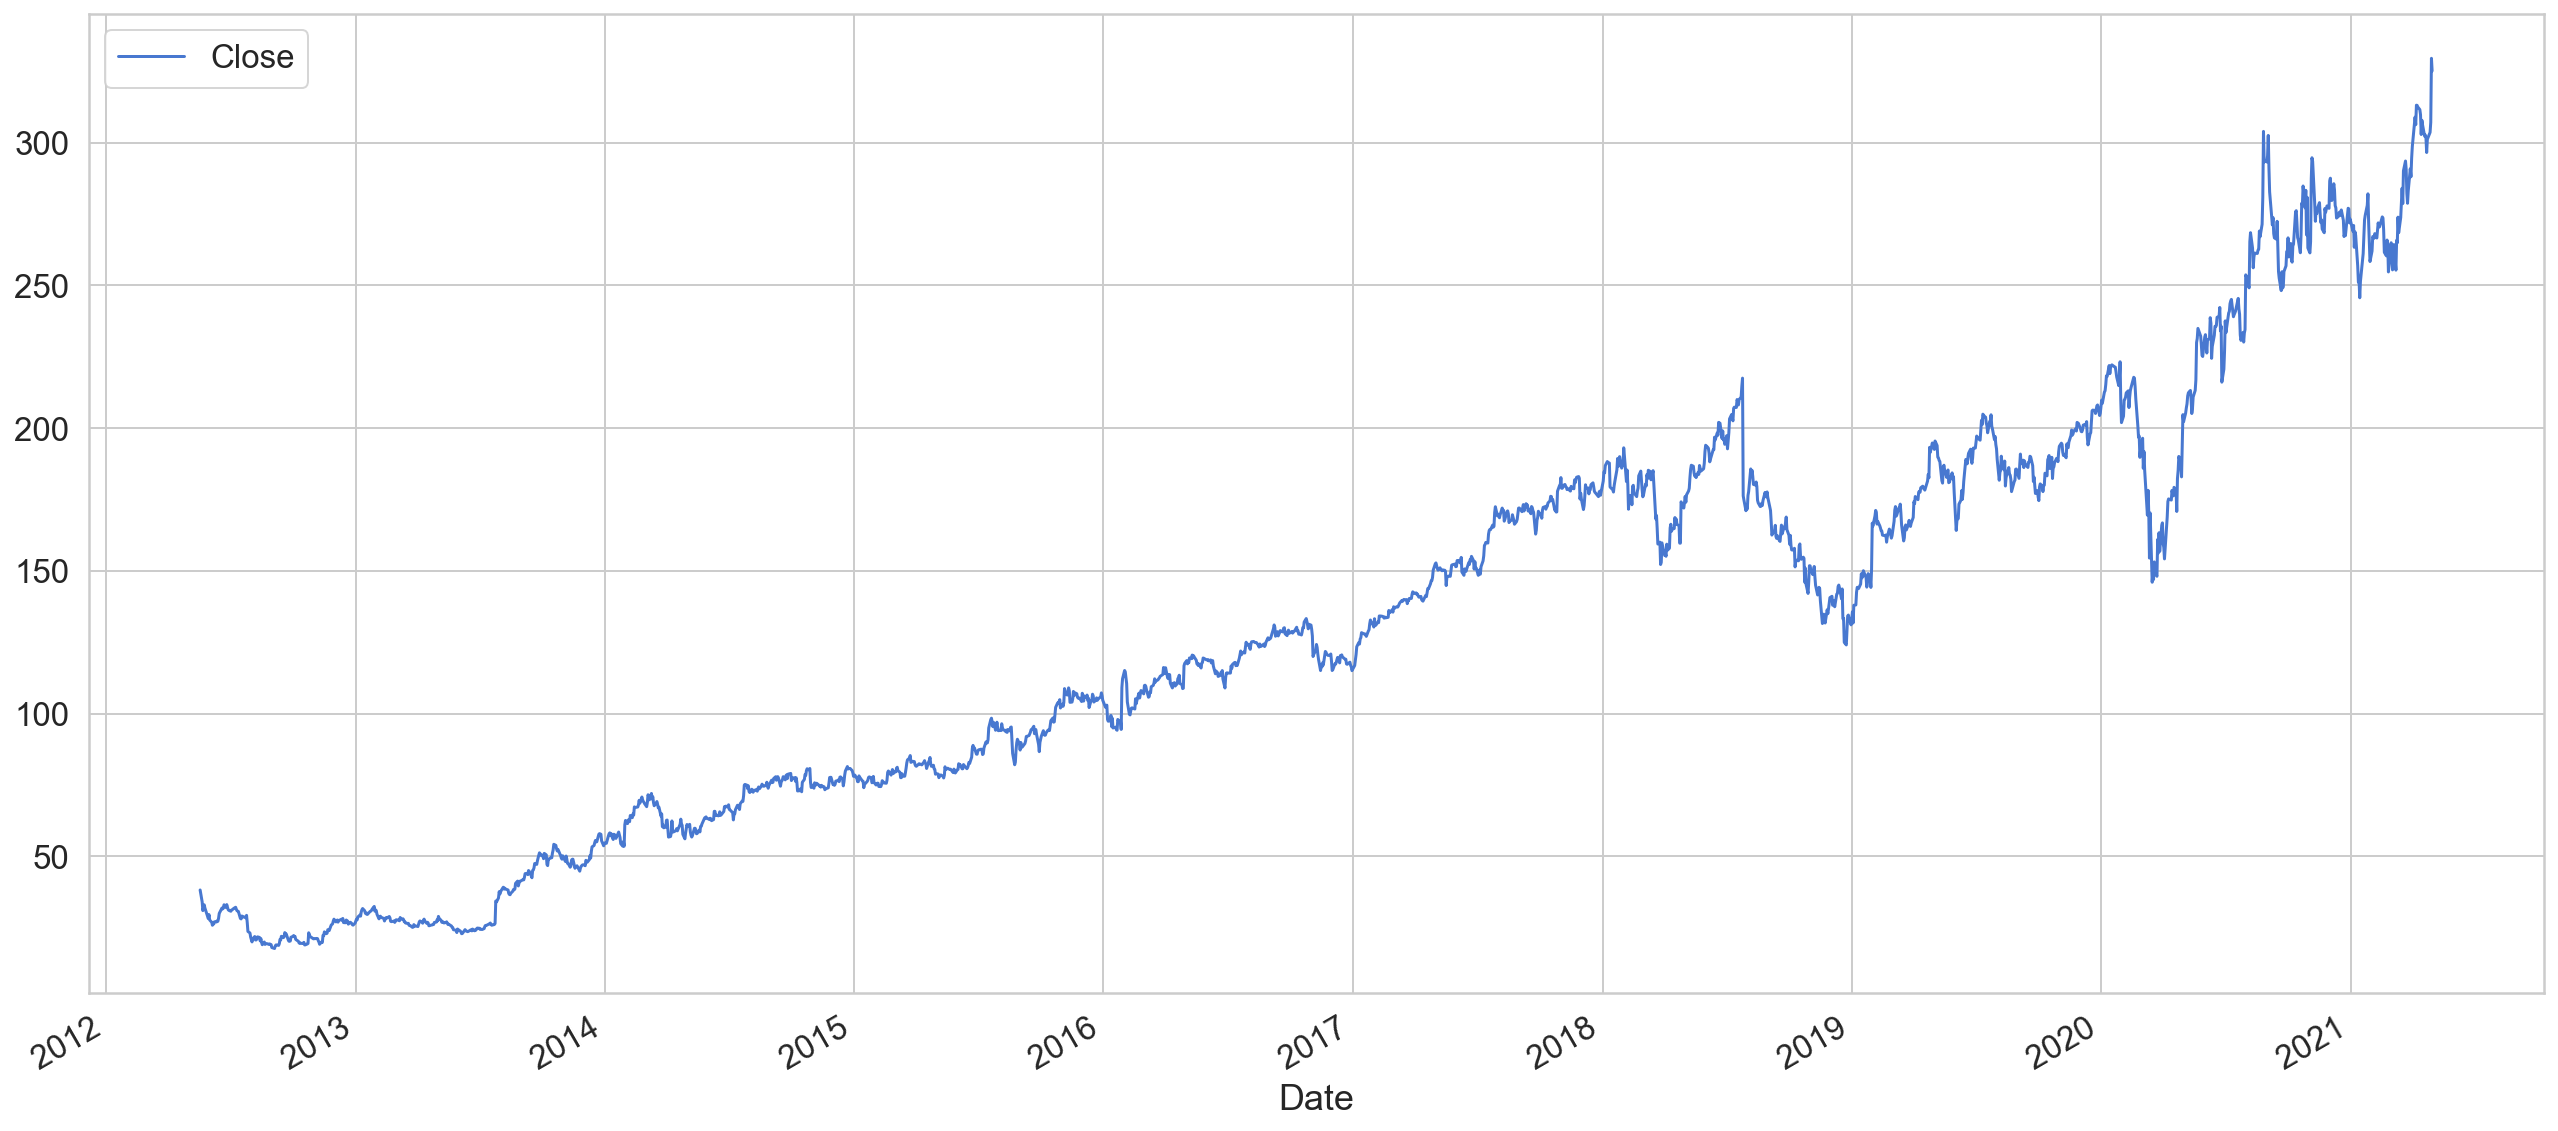

In [24]:
orig_df.plot()
plt.show()

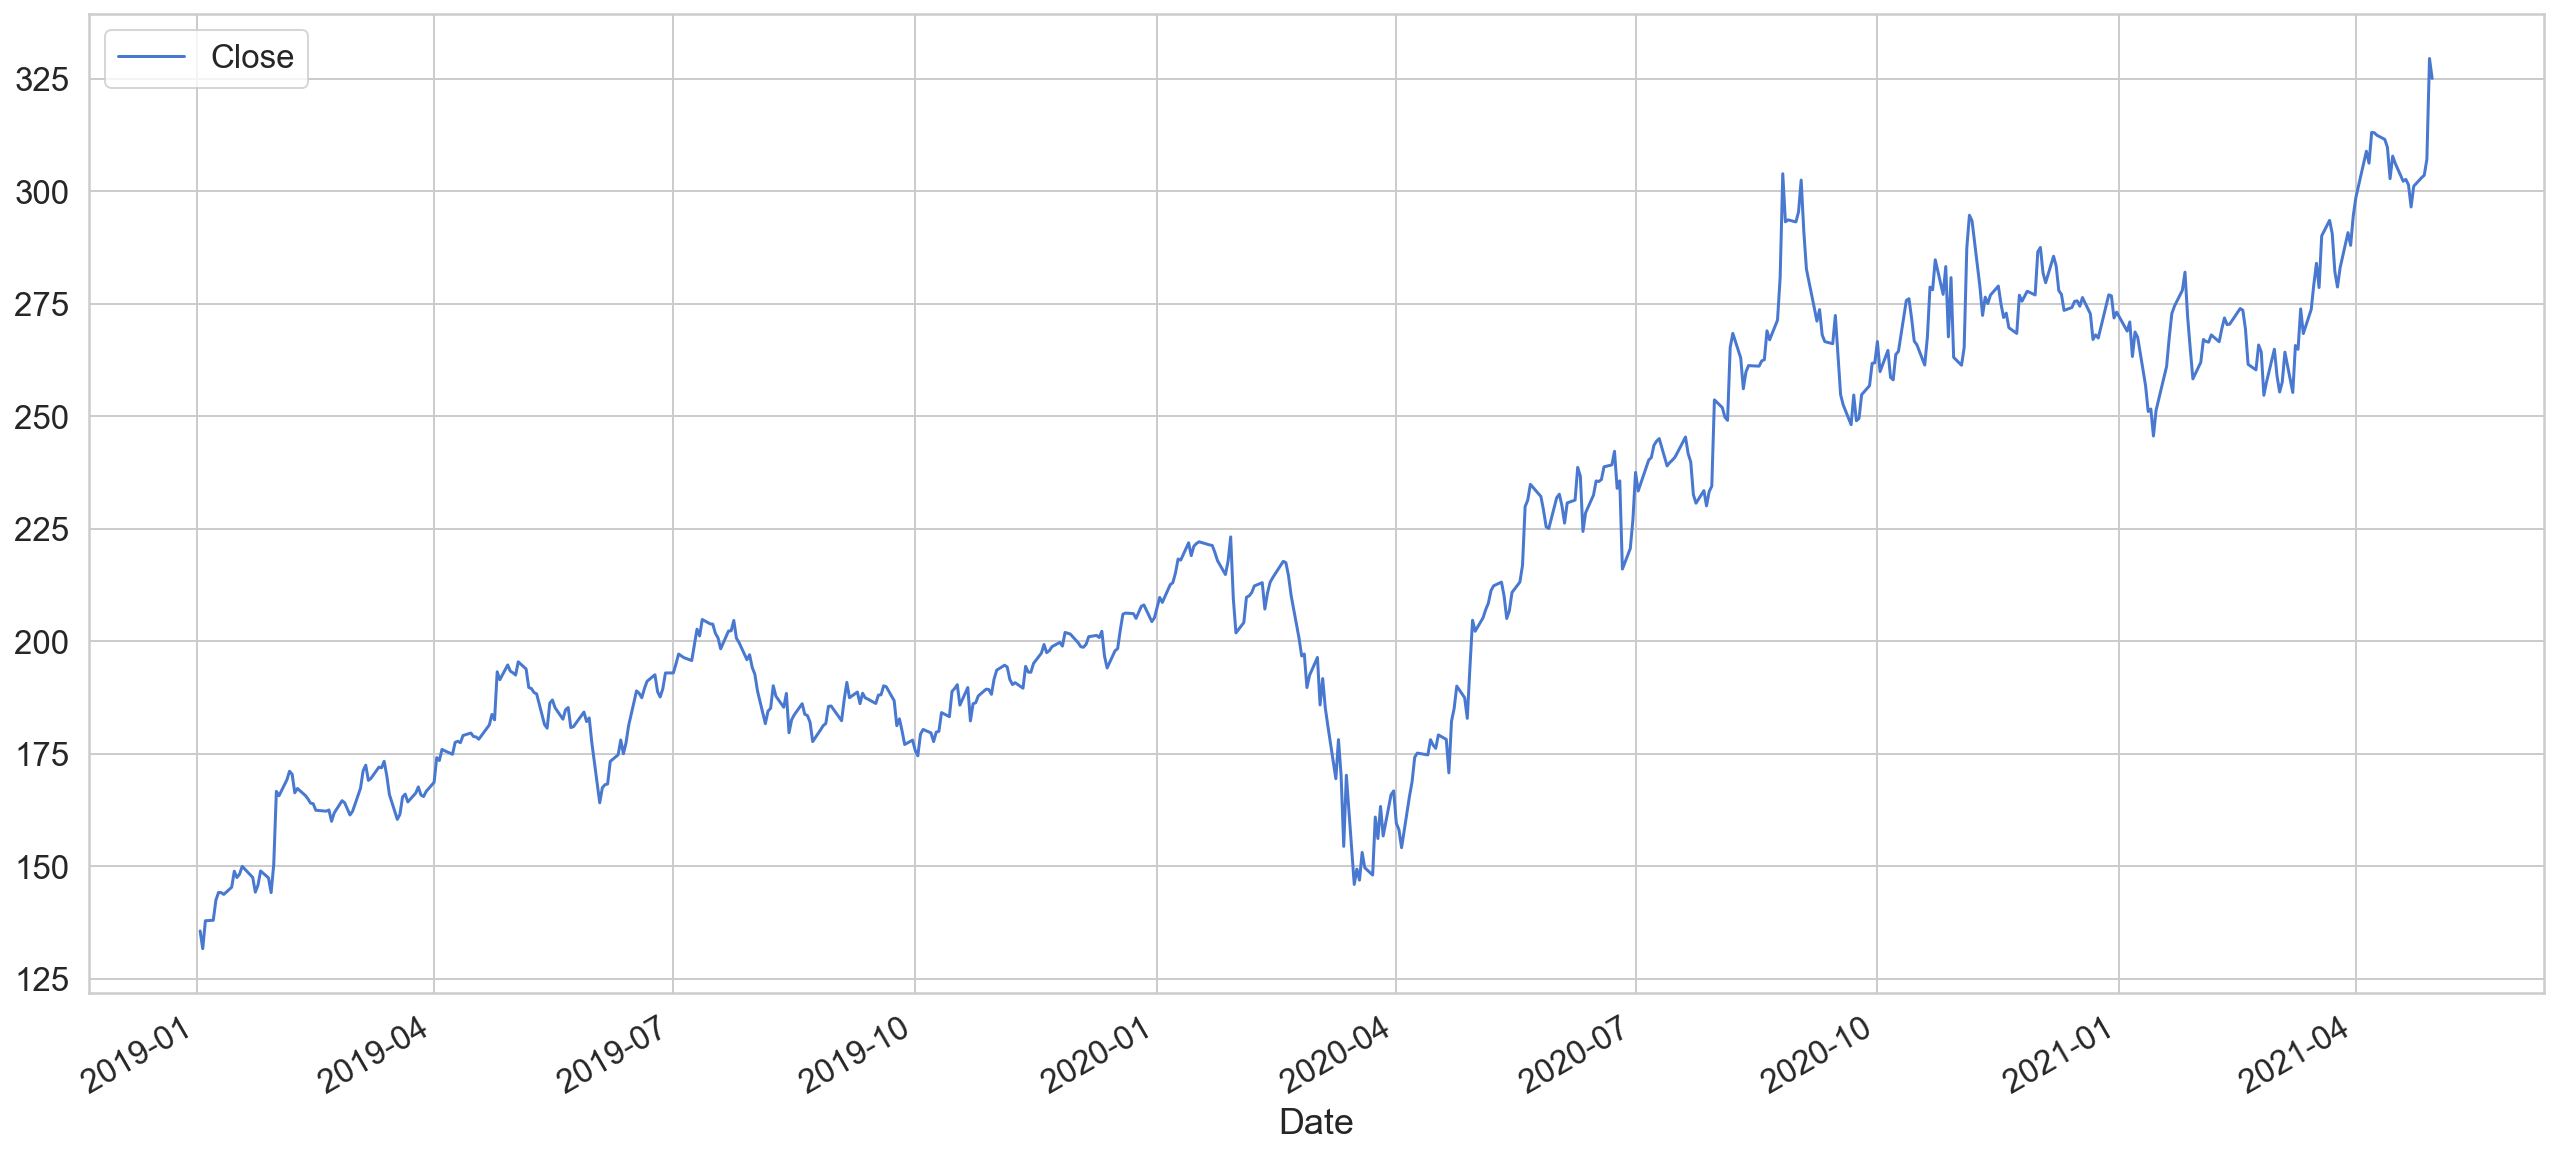

In [25]:
orig_df.loc['2019':].plot()
plt.show()

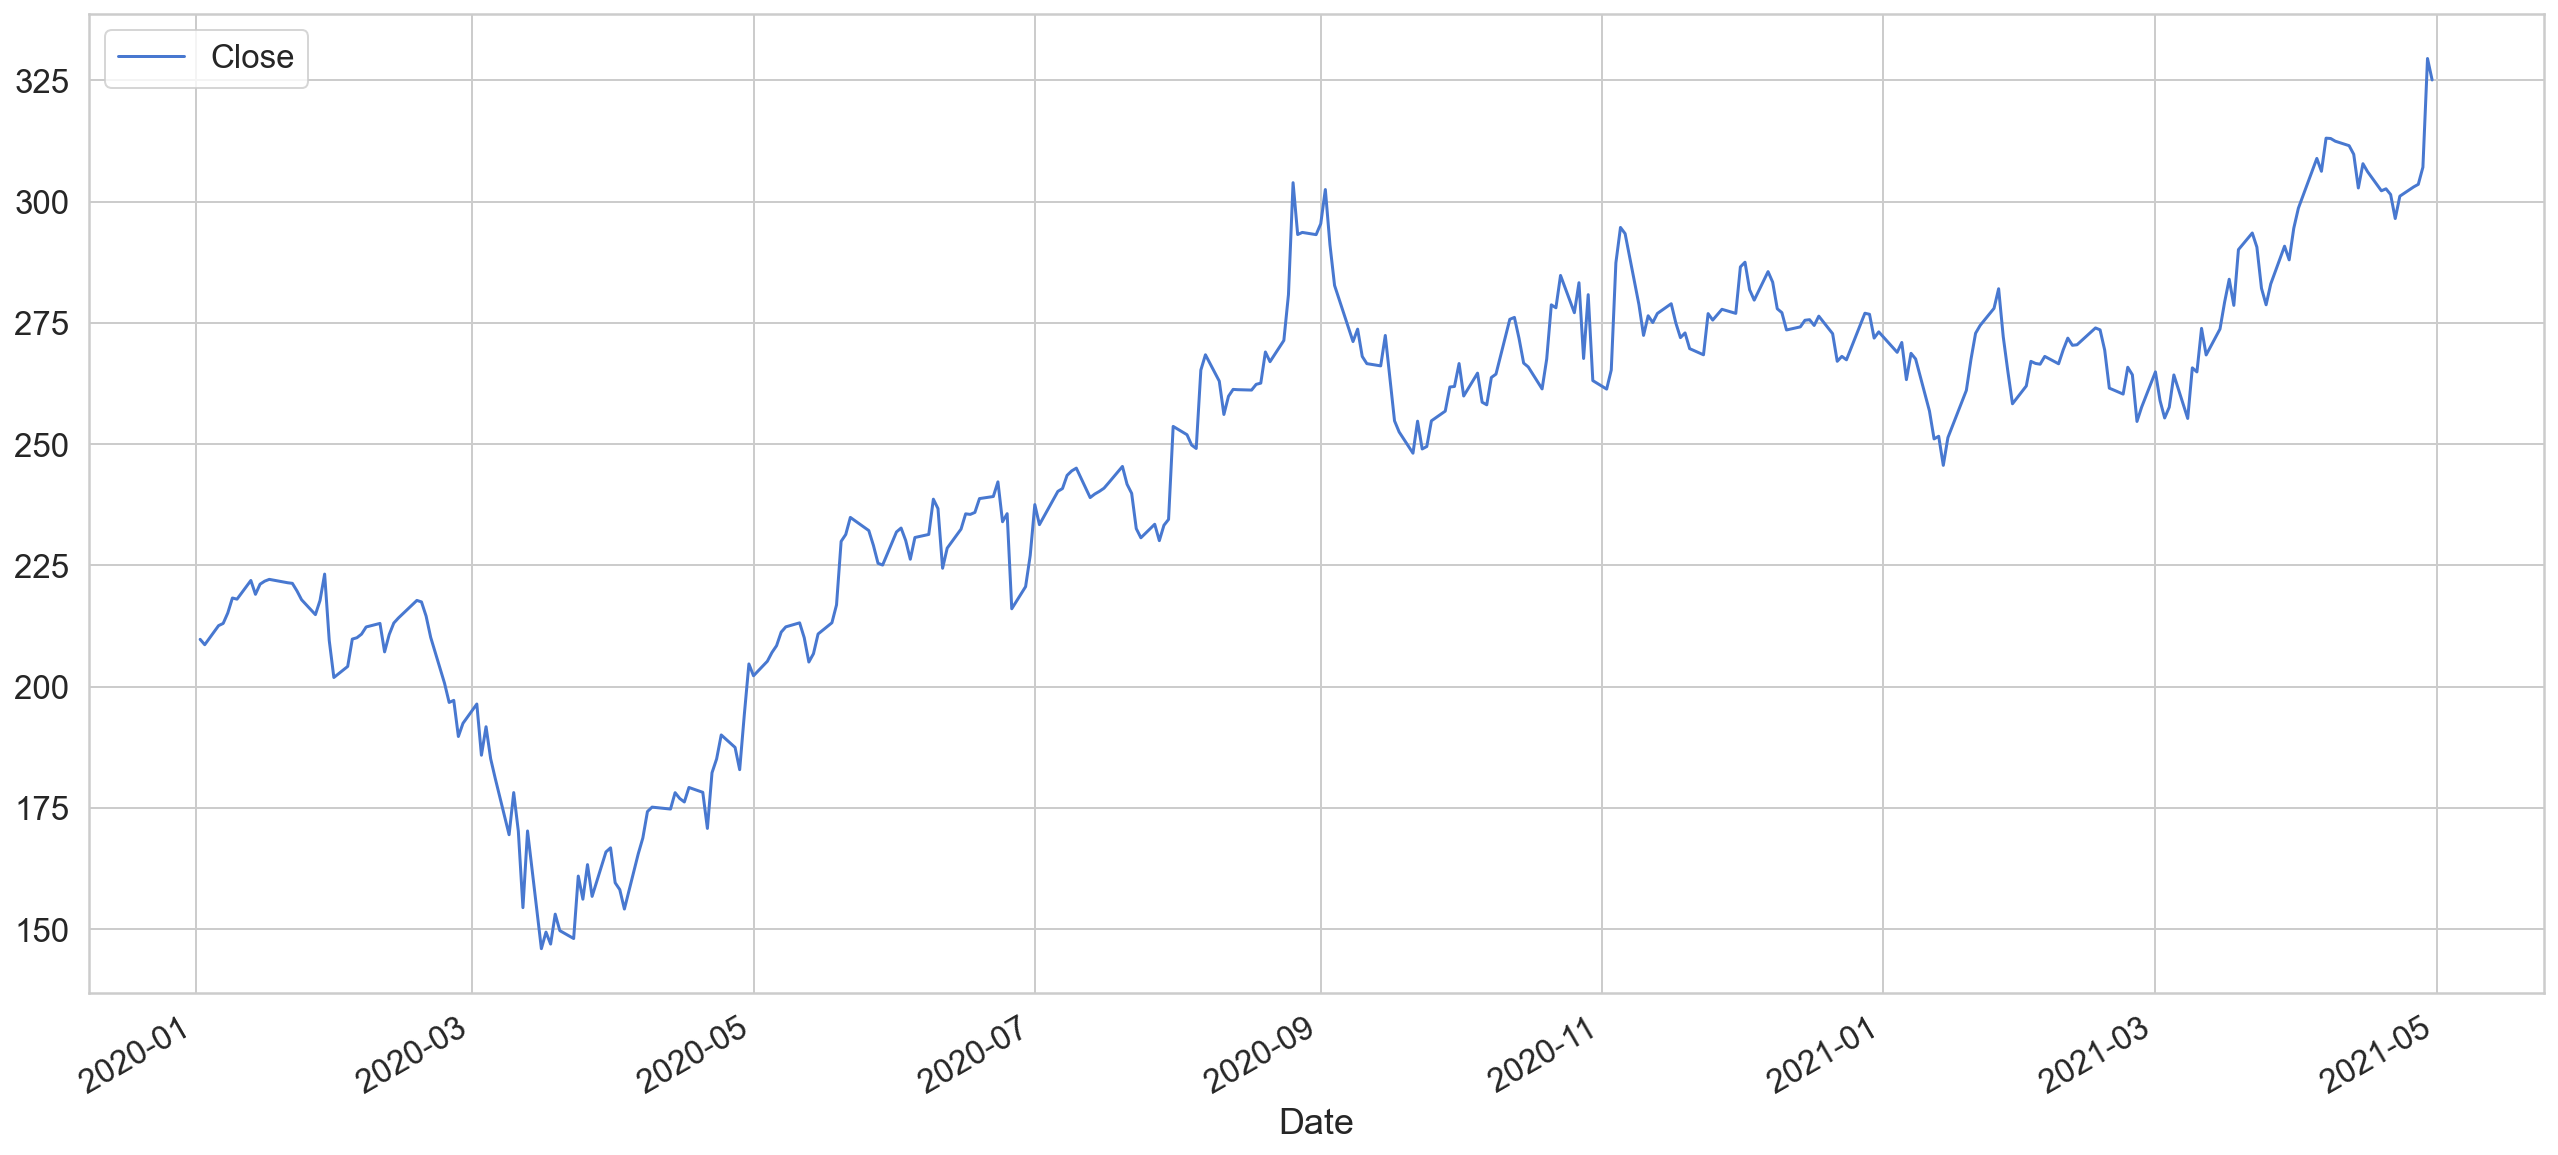

In [26]:
orig_df.loc['2020':].plot()
plt.show()

In [28]:
# take only 2020 until now
# df = orig_df.loc['2020':].copy()
df = orig_df.copy()
df.head()

,Close
Date,
2012-05-18,38.230000
2012-05-21,34.029999
2012-05-22,31.000000
2012-05-23,32.000000
2012-05-24,33.029999


# Testing for Stationary Characteristics

**Augmented Dickey–Fuller (ADF) test**

$H_0$ : The time series has a unit root (non-stationary/seasonal).<br>
$H_1$ : The time series does not have a unit root (stationary).

In [29]:
from statsmodels.tsa.stattools import adfuller

In [30]:
def adfuller_test(df):
    result = adfuller(df)
    labels = ['ADF Test Statistic', 'p-value', 
              '#Lags Used', 'Number of Observations Used']
    p = result[1]
    
    half_length = len(df) // 2
    first_half = df.iloc[:half_length]
    second_half = df.iloc[half_length:]
    print(f"Mean 1: {first_half.mean()}")
    print(f"Mean 2: {second_half.mean()}")
    print(f"Variance 2: {second_half.var()}")
    print(f"Variance 2: {second_half.var()}\n")
    
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
        
    if p <= 0.05:
        print(f"Significant evidence against the null hypothesis (p = {p:.3f}), "
              "reject the null hypothesis.\n"
              "Data has no unit root and is stationary.")
    else:
        print(f"Insufficient evidence against null hypothesis (p = {p:.3f}), "
              f"do not reject null hypothesis.\n"
              "Time series has a unit root, indicating it is non-stationary or has seasonality.")

In [31]:
adfuller_test(df['Close'])

Mean 1: 68.88436945886426
Mean 2: 190.71498210900208
Variance 2: 2107.762561498844
Variance 2: 2107.762561498844

ADF Test Statistic : 0.37517831363073945
p-value : 0.9805425896828134
#Lags Used : 18
Number of Observations Used : 2233
Insufficient evidence against null hypothesis (p = 0.981), do not reject null hypothesis.
Time series has a unit root, indicating it is non-stationary or has seasonality.


In [32]:
df['Seasonal First Difference'] = df - df.shift(12)

In [33]:
adfuller_test(df['Seasonal First Difference'].dropna())

Mean 1: 0.9845892923218863
Mean 2: 1.9787946360451834
Variance 2: 158.56045250818897
Variance 2: 158.56045250818897

ADF Test Statistic : -6.913156686494487
p-value : 1.1979607798670442e-09
#Lags Used : 25
Number of Observations Used : 2214
Significant evidence against the null hypothesis (p = 0.000), reject the null hypothesis.
Data has no unit root and is stationary.


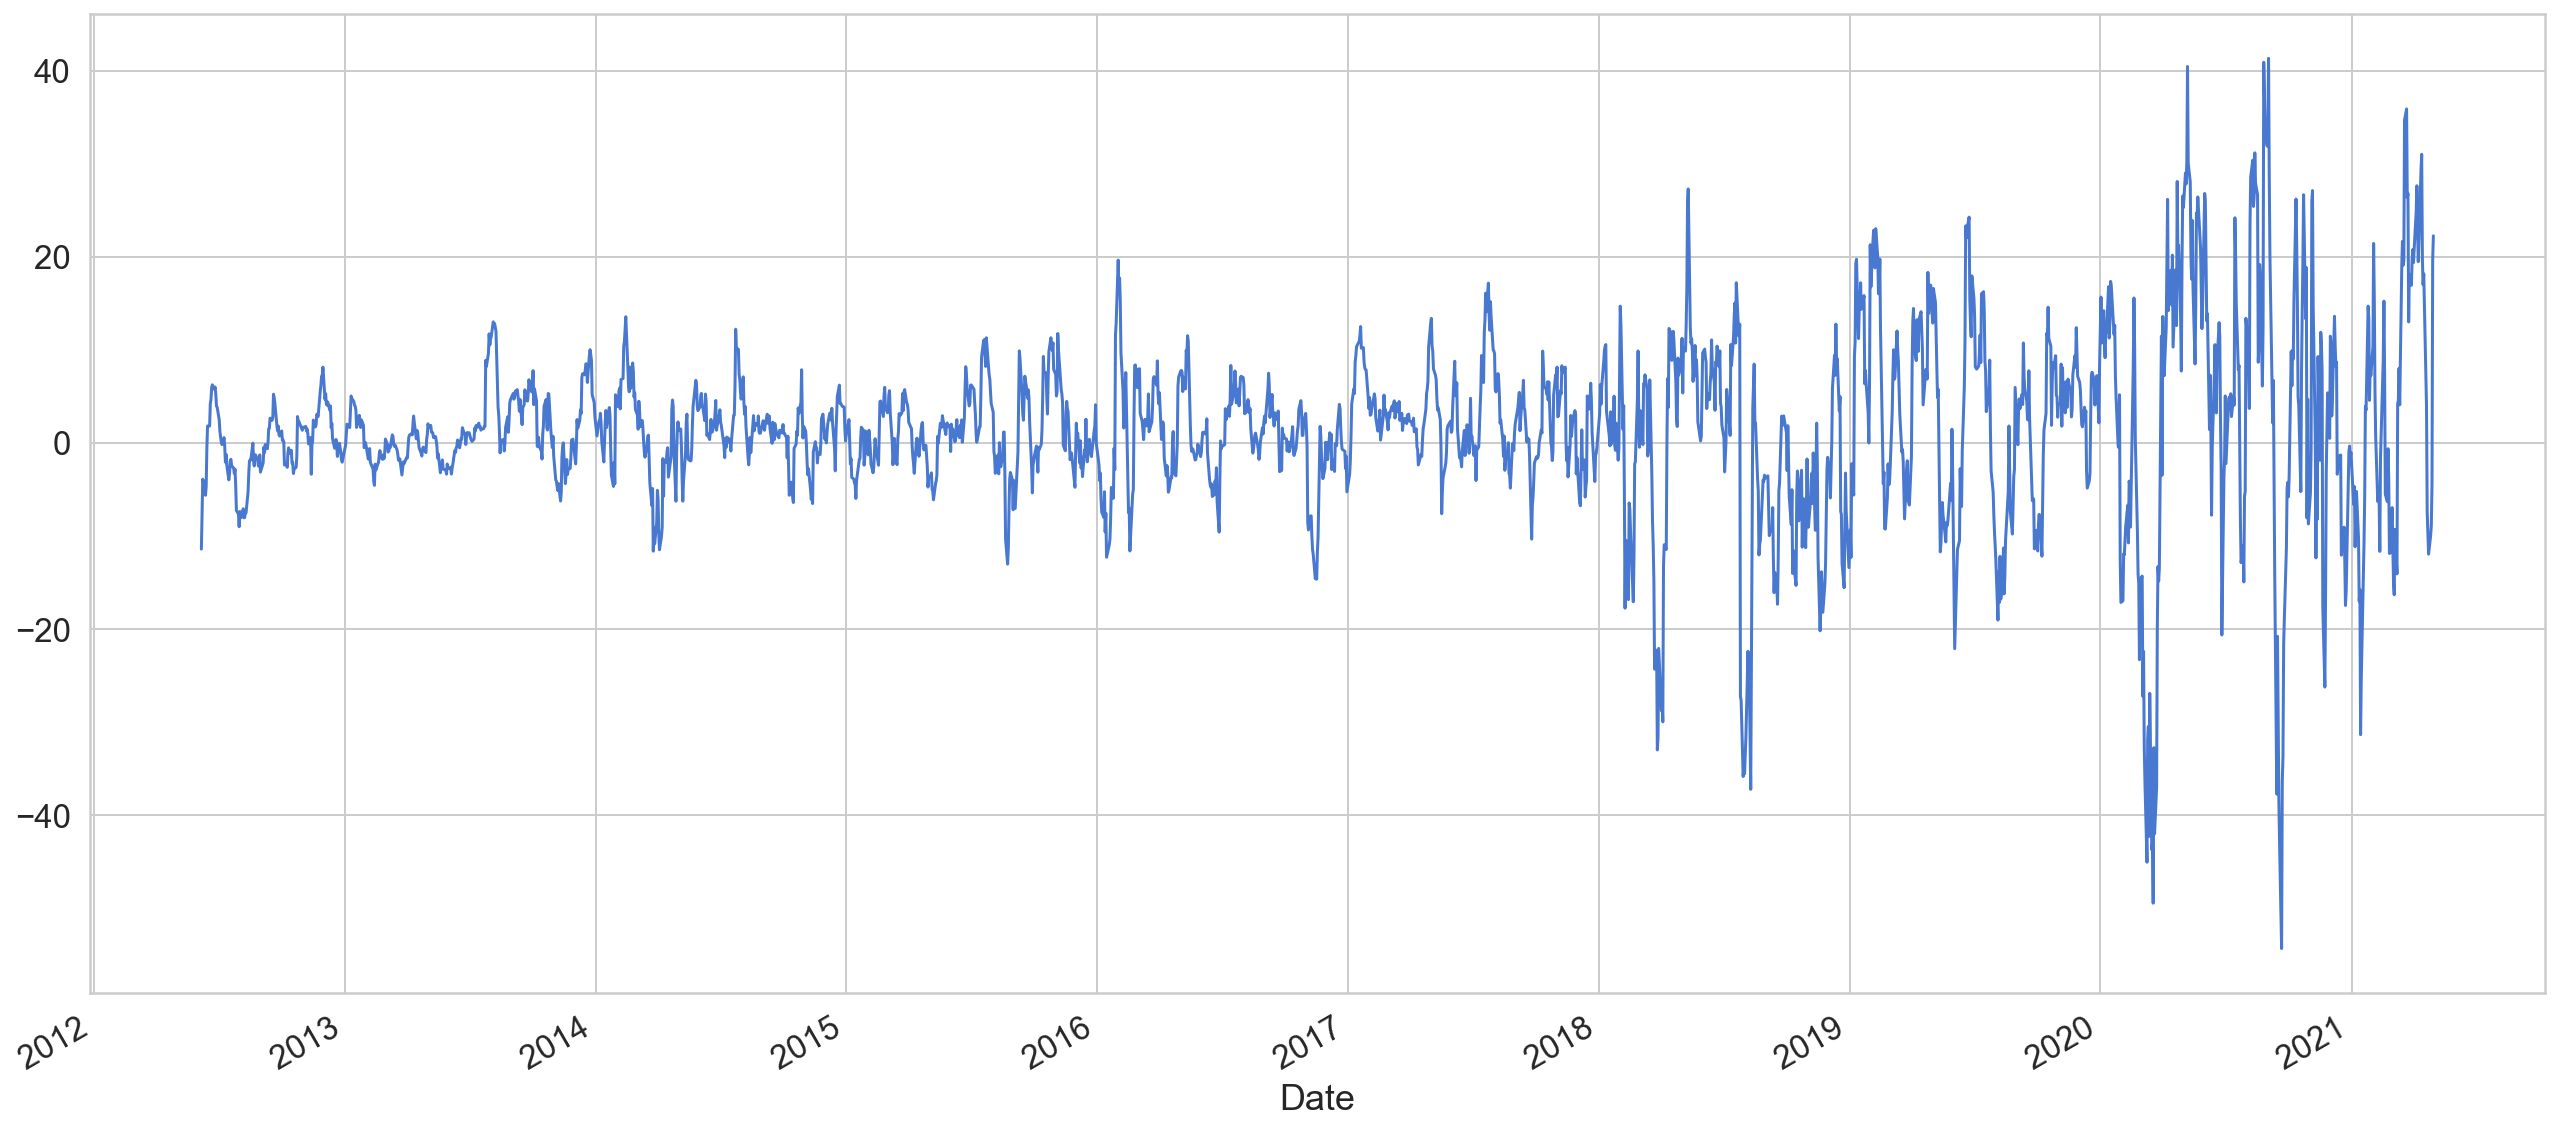

In [34]:
df['Seasonal First Difference'].plot()
plt.show()

In [35]:
df.head()

,Close,Seasonal First Difference
Date,,
2012-05-18,38.230000,NaN
2012-05-21,34.029999,NaN
2012-05-22,31.000000,NaN
2012-05-23,32.000000,NaN
2012-05-24,33.029999,NaN


# Identifying Parameters for ARIMA

ARIMA = Autoregressive Integrated Moving Average

Parameters required: p, d, q 
- p: AR lags 
- d: differencing  (integrated)
- q: MA lags
- Identification of p through Partial Autocorrelation Function 
- Identification of q through Autocorrelation Function

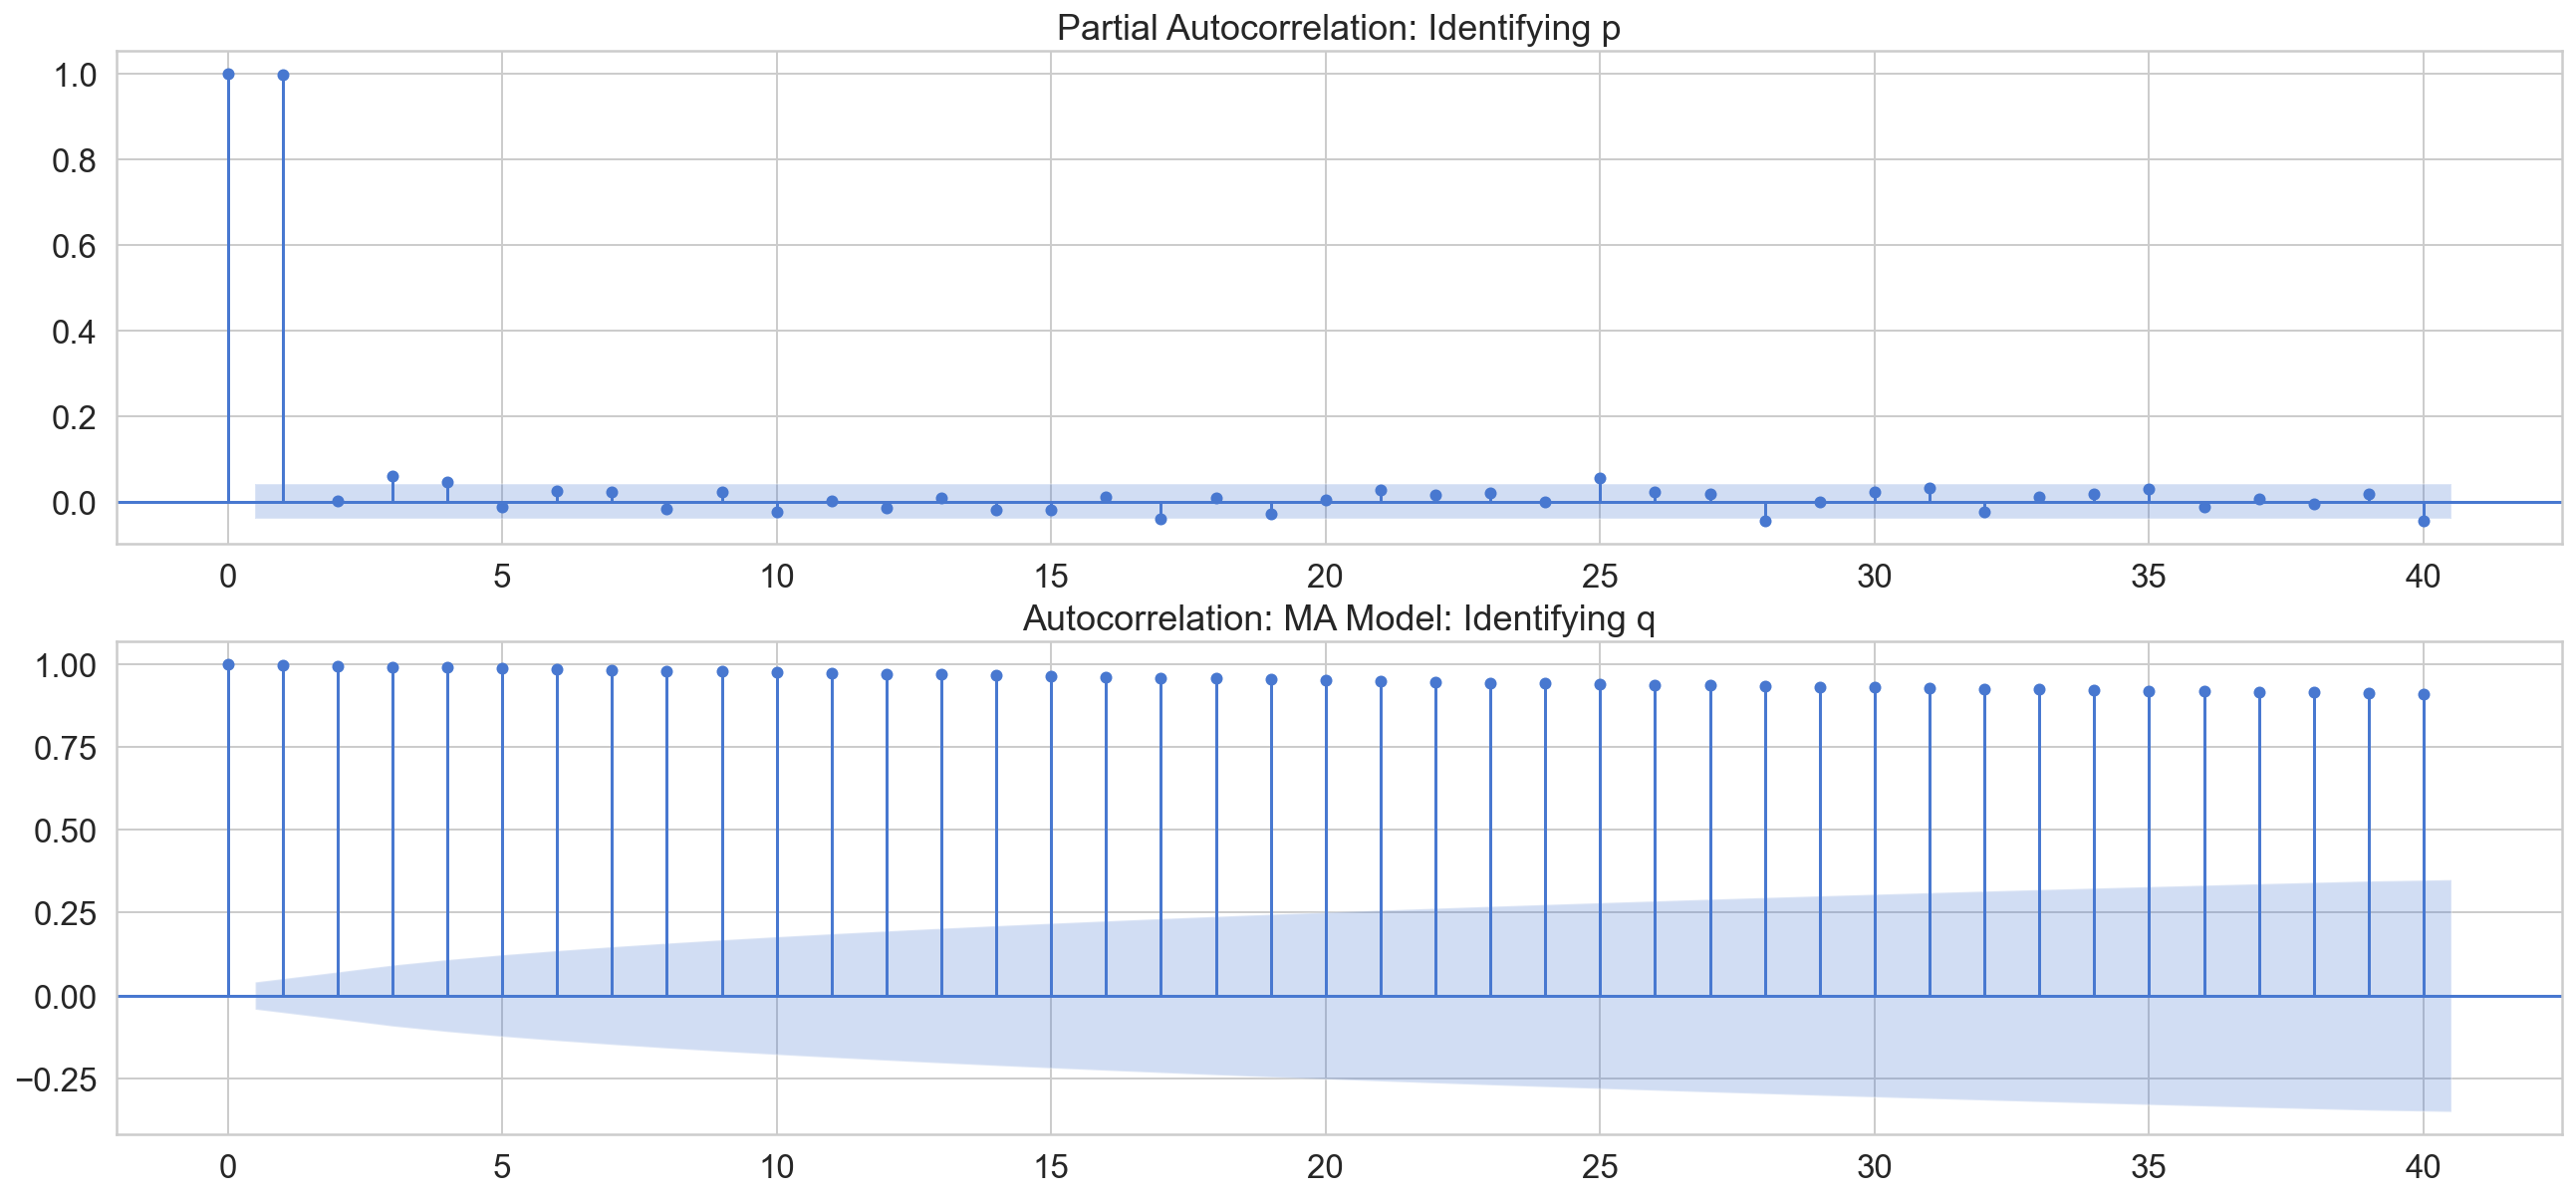

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(2)
plot_pacf(df['Close'], lags=40, ax=axs[0], title='Partial Autocorrelation: Identifying p')
plot_acf(df['Close'], lags=40, ax=axs[1], title='Autocorrelation: MA Model: Identifying q')
plt.show()

- This is a model with severe seasonality. 
- Therefore the Autocorrelation plot is very ambiguous for identifying q.
- ARIMA will very likely not perform well too.

# ARIMA

In [37]:
# CONFIG
order = (2, 1, 26)
p, d, q = order
forecast_len = 30

In [38]:
# Split the data for training and testing
# X, y = df.iloc[:-forecast_len], df.iloc[-forecast_len:]
# len(y)

In [39]:
# from statsmodels.tsa.arima.model import ARIMA
# model = ARIMA(X, order=order)
# results = model.fit()

In [40]:
# pred = results.forecast(forecast_len)

In [41]:
# pred.index = df.index[-forecast_len:]
# df['Forecasted'] = pred

In [42]:
# from sklearn.metrics import mean_squared_error
# mean_squared_error(y, pred, squared=False)

In [43]:
# df.plot()
# plt.show()

## Second Method

In [44]:
start_date = str(df.iloc[-forecast_len].name.date())
end_date = str(df.iloc[-1].name.date())

In [75]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def fit_predict(df, order, forecast_len=30, plot=True, return_df=False):
    print("Start date\t: ", start_date)
    print("End date\t: ", end_date)
    print("Forecast days\t: ", forecast_len)
    print()
    print("(p, d, q)\t: ", order)
    
    
    model = ARIMA(df['Close'], order=order)
    fitted_model = model.fit()
    df['Predictions'] = fitted_model.predict(start=start_date,end=end_date, dynamic=True)
    
    rmse = mean_squared_error(df.dropna()['Close'], df.dropna()[['Predictions']], squared=False)
    print("\nRMSE\t= ", rmse)
    print("AIC\t= ", fitted_model.aic)
    
    if plot:
        df[['Close','Predictions']].plot()
        plt.show()
    
    if return_df:
        return fitted_model, df
    
    return fitted_model

Start date	:  2021-03-19
End date	:  2021-04-30
Forecast days	:  30

(p, d, q)	:  (2, 1, 26)


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.




RMSE	=  24.53915383850592
AIC	=  11548.307471393535


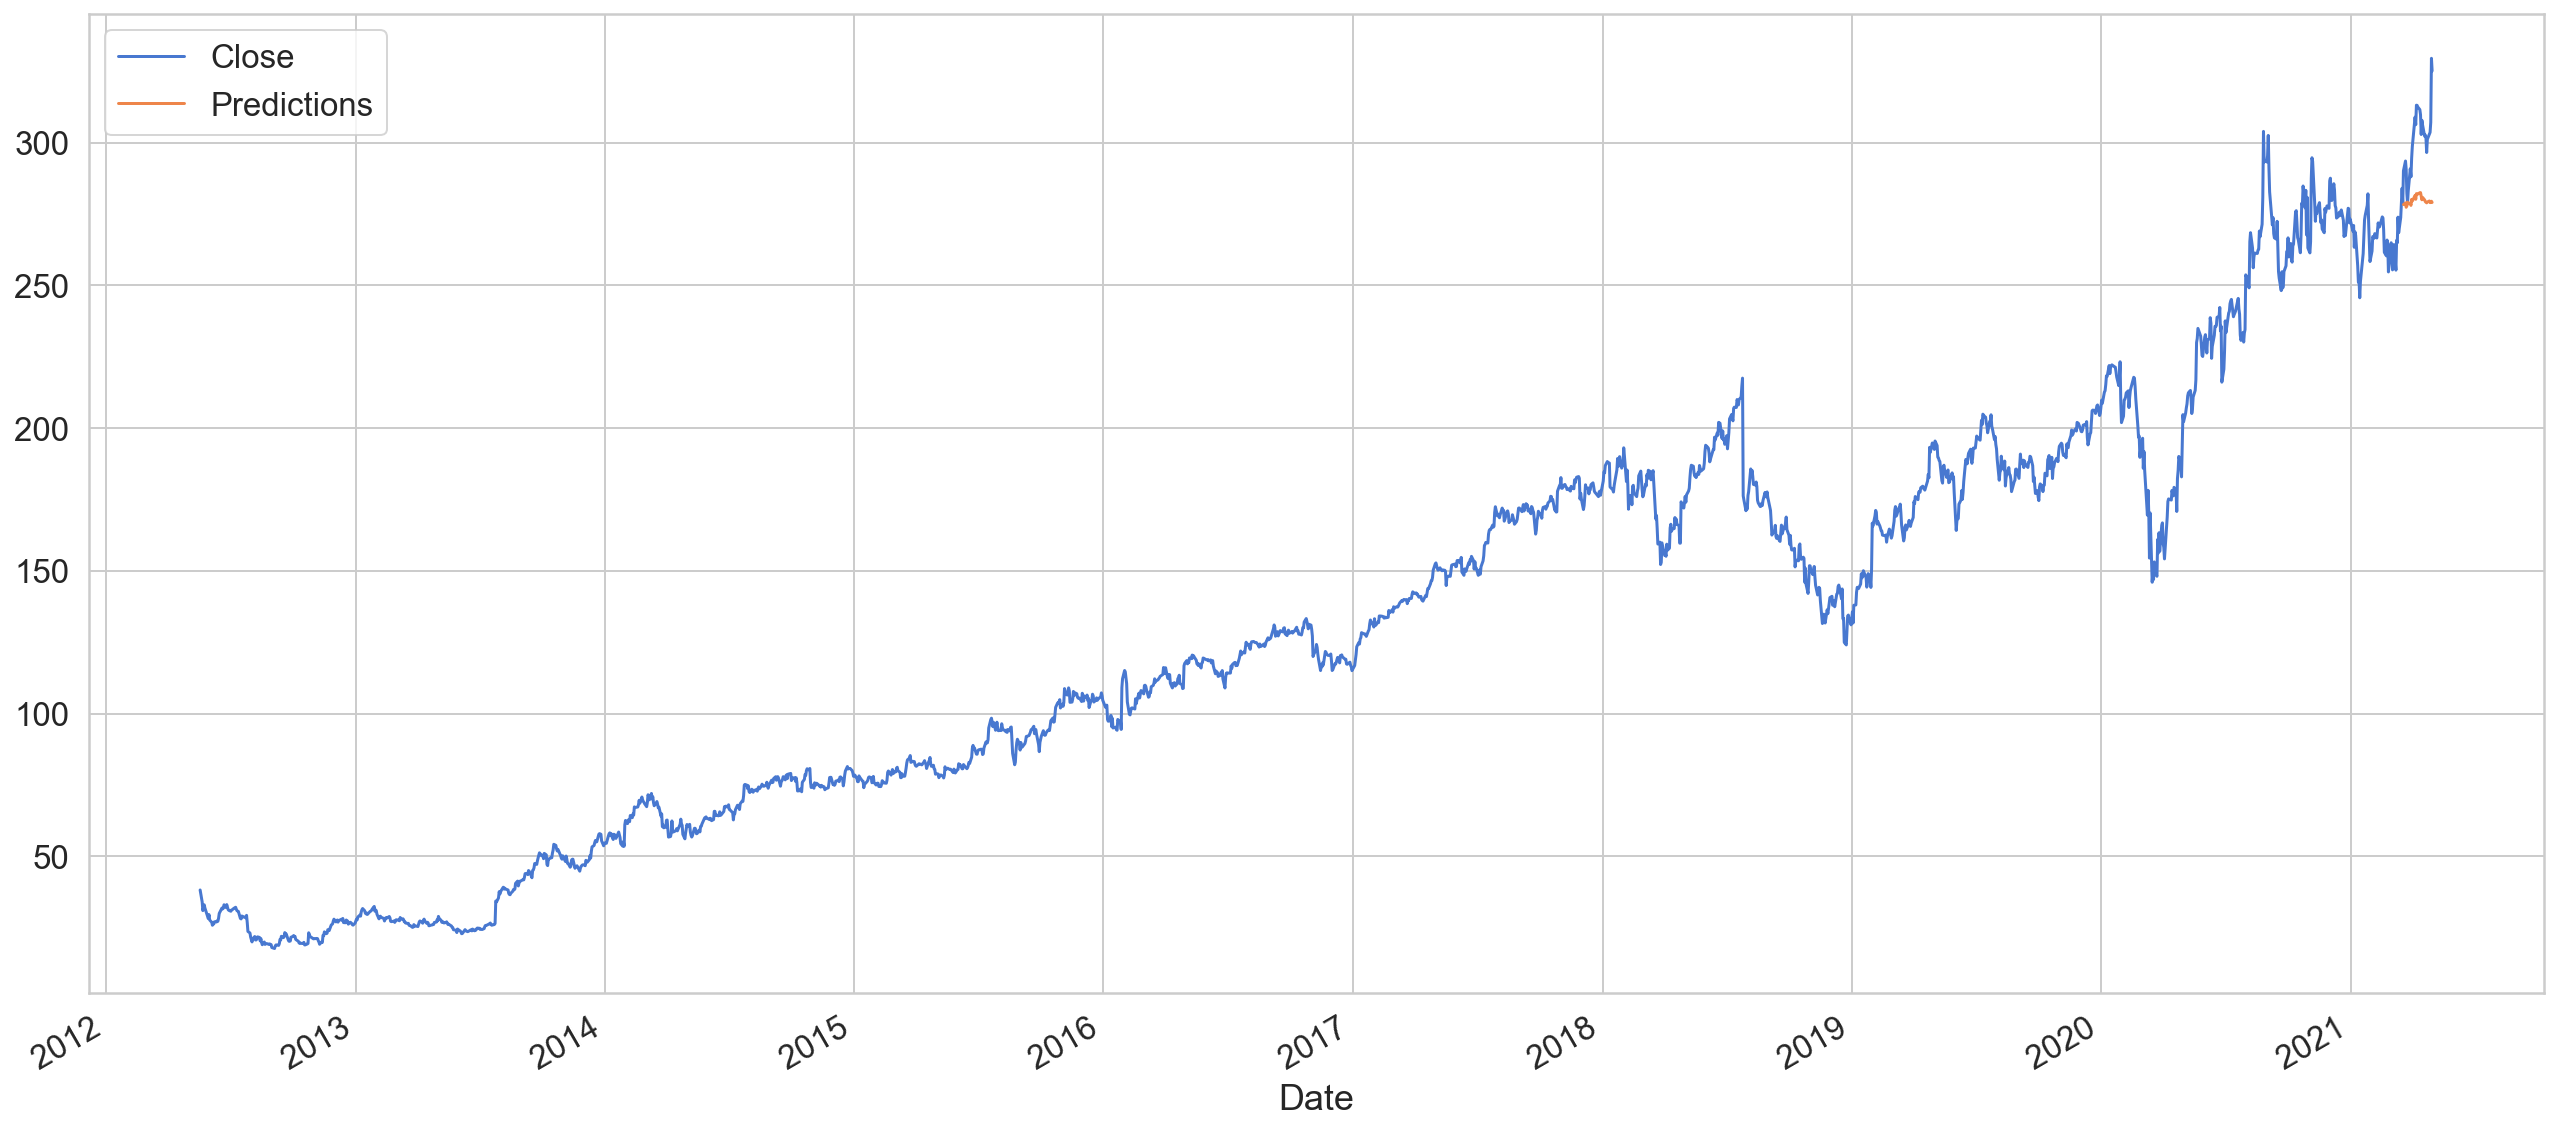

In [46]:
fitted_model = fit_predict(df, order=order, forecast_len=forecast_len)

In [47]:
# Basically same results with 2 different ways to get predictions.
#  So actually we don't need to split the dataset first

# (df['Forecasted'].dropna() == df['Predictions'].dropna()).all()

# OUTPUT: True

# SARIMAX

In [48]:
order

(2, 1, 26)

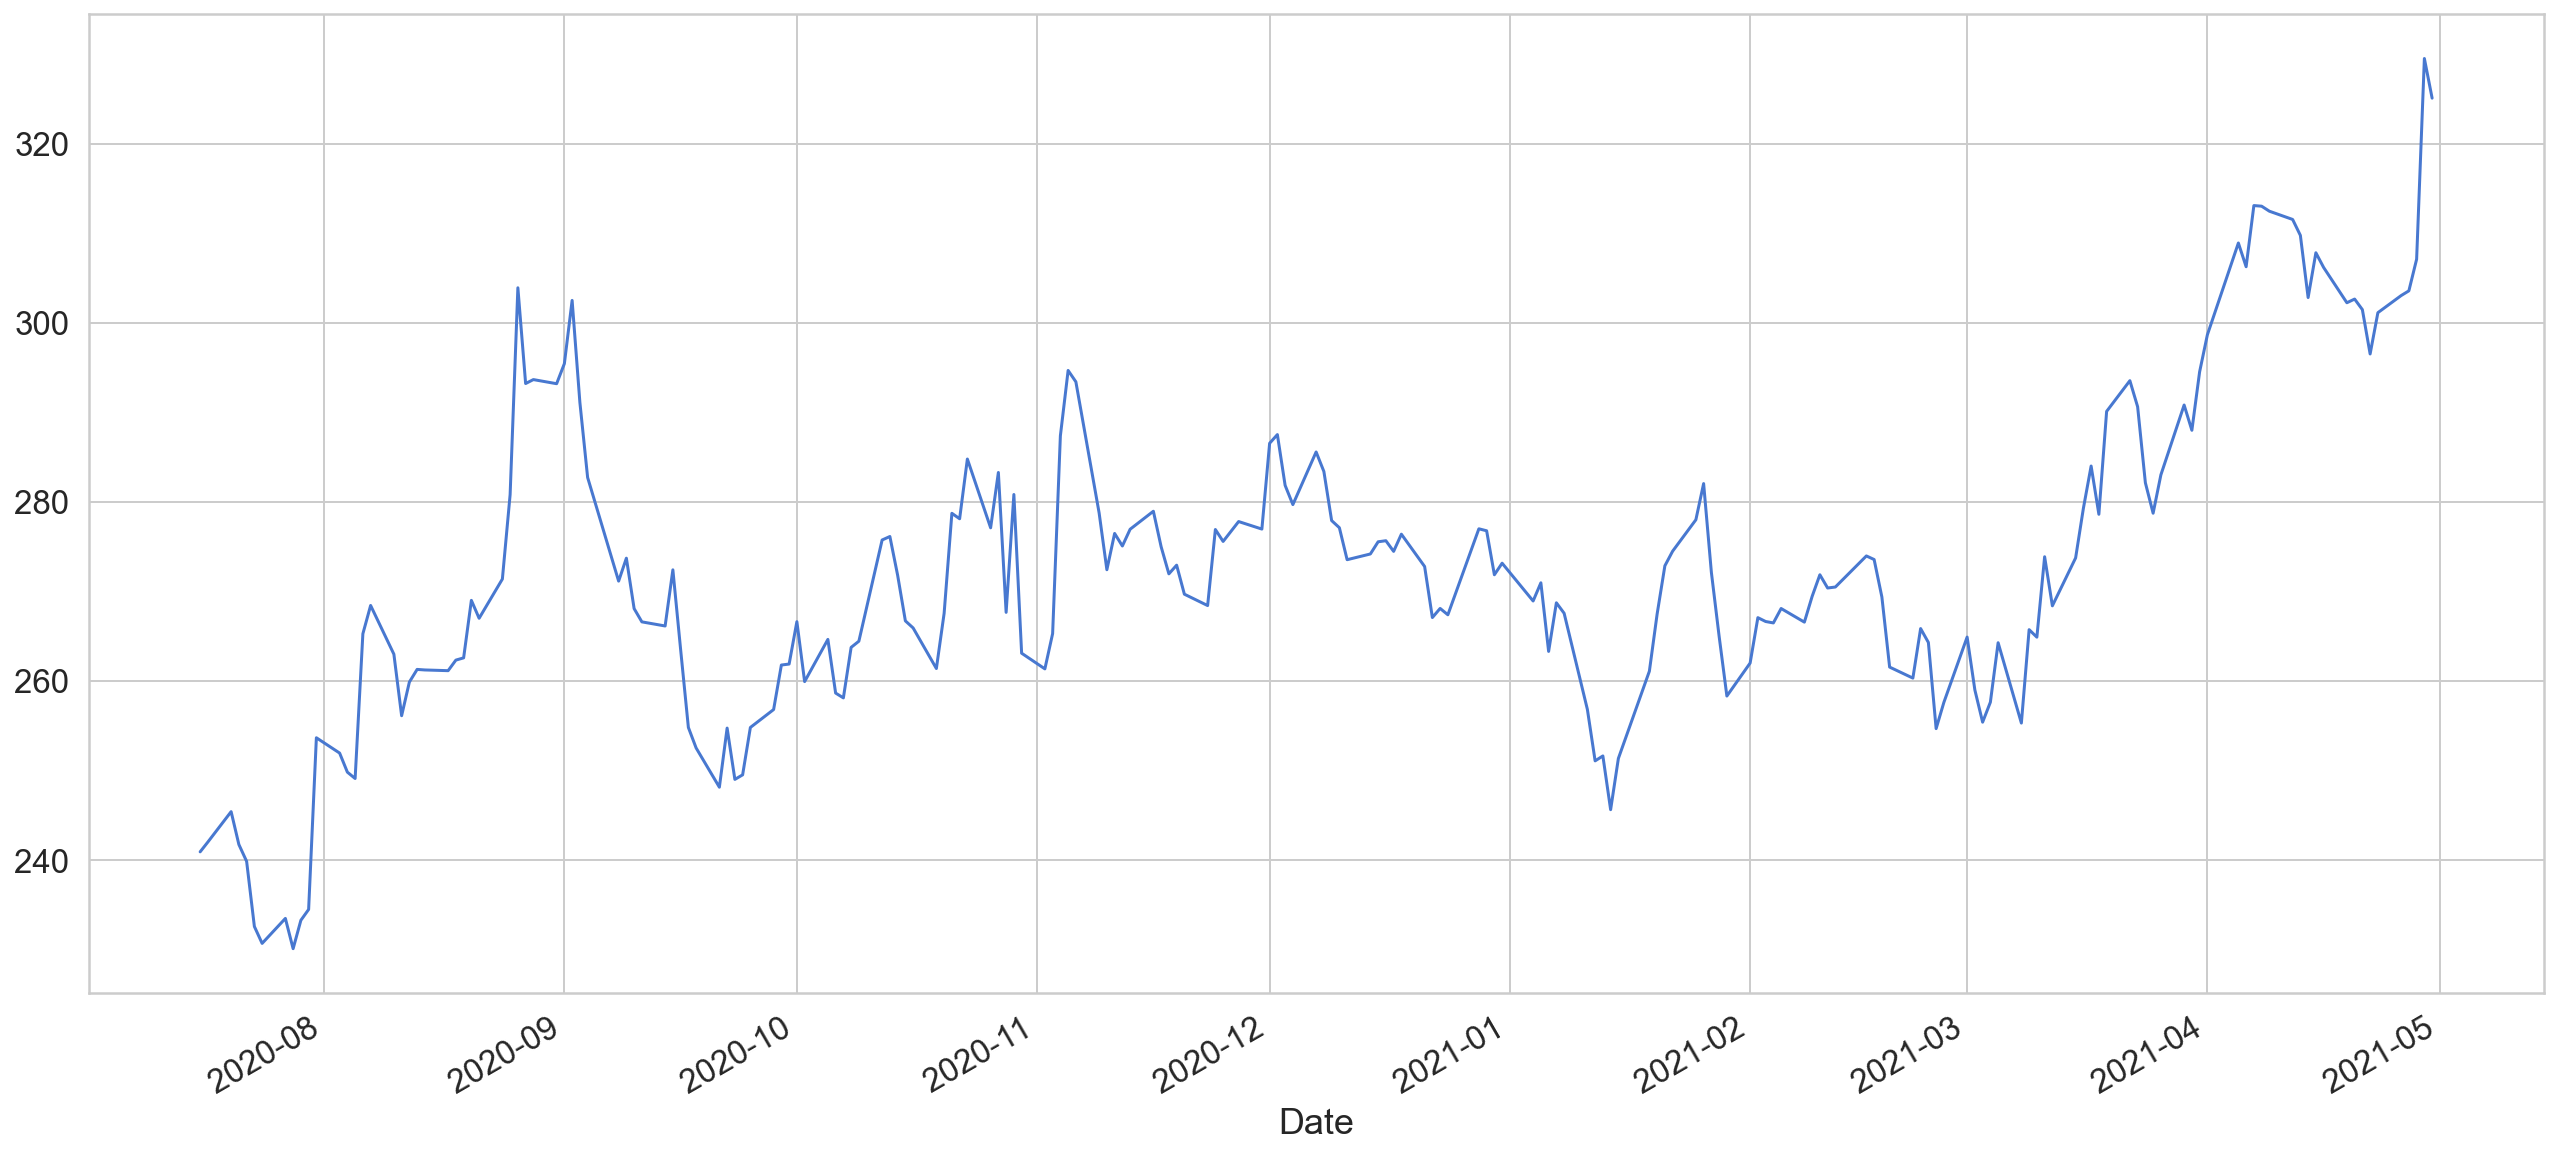

In [49]:
df.iloc[-200:, 0].plot()
plt.show()

In [50]:
# determine the parameter for seasonality
# periodicity (number of periods in season)
periodicity = 12  # 12 for monthly data
# seasonal_order = (*order, periodicity)
seasonal_order = (4, 3, 5, periodicity)
seasonal_order

(4, 3, 5, 12)

In [51]:
# ARIMA for non-seasonal model, SARIMAX for seasonal
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['Close'], seasonal_order=seasonal_order)
results = model.fit()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [52]:
start_date

'2021-03-19'

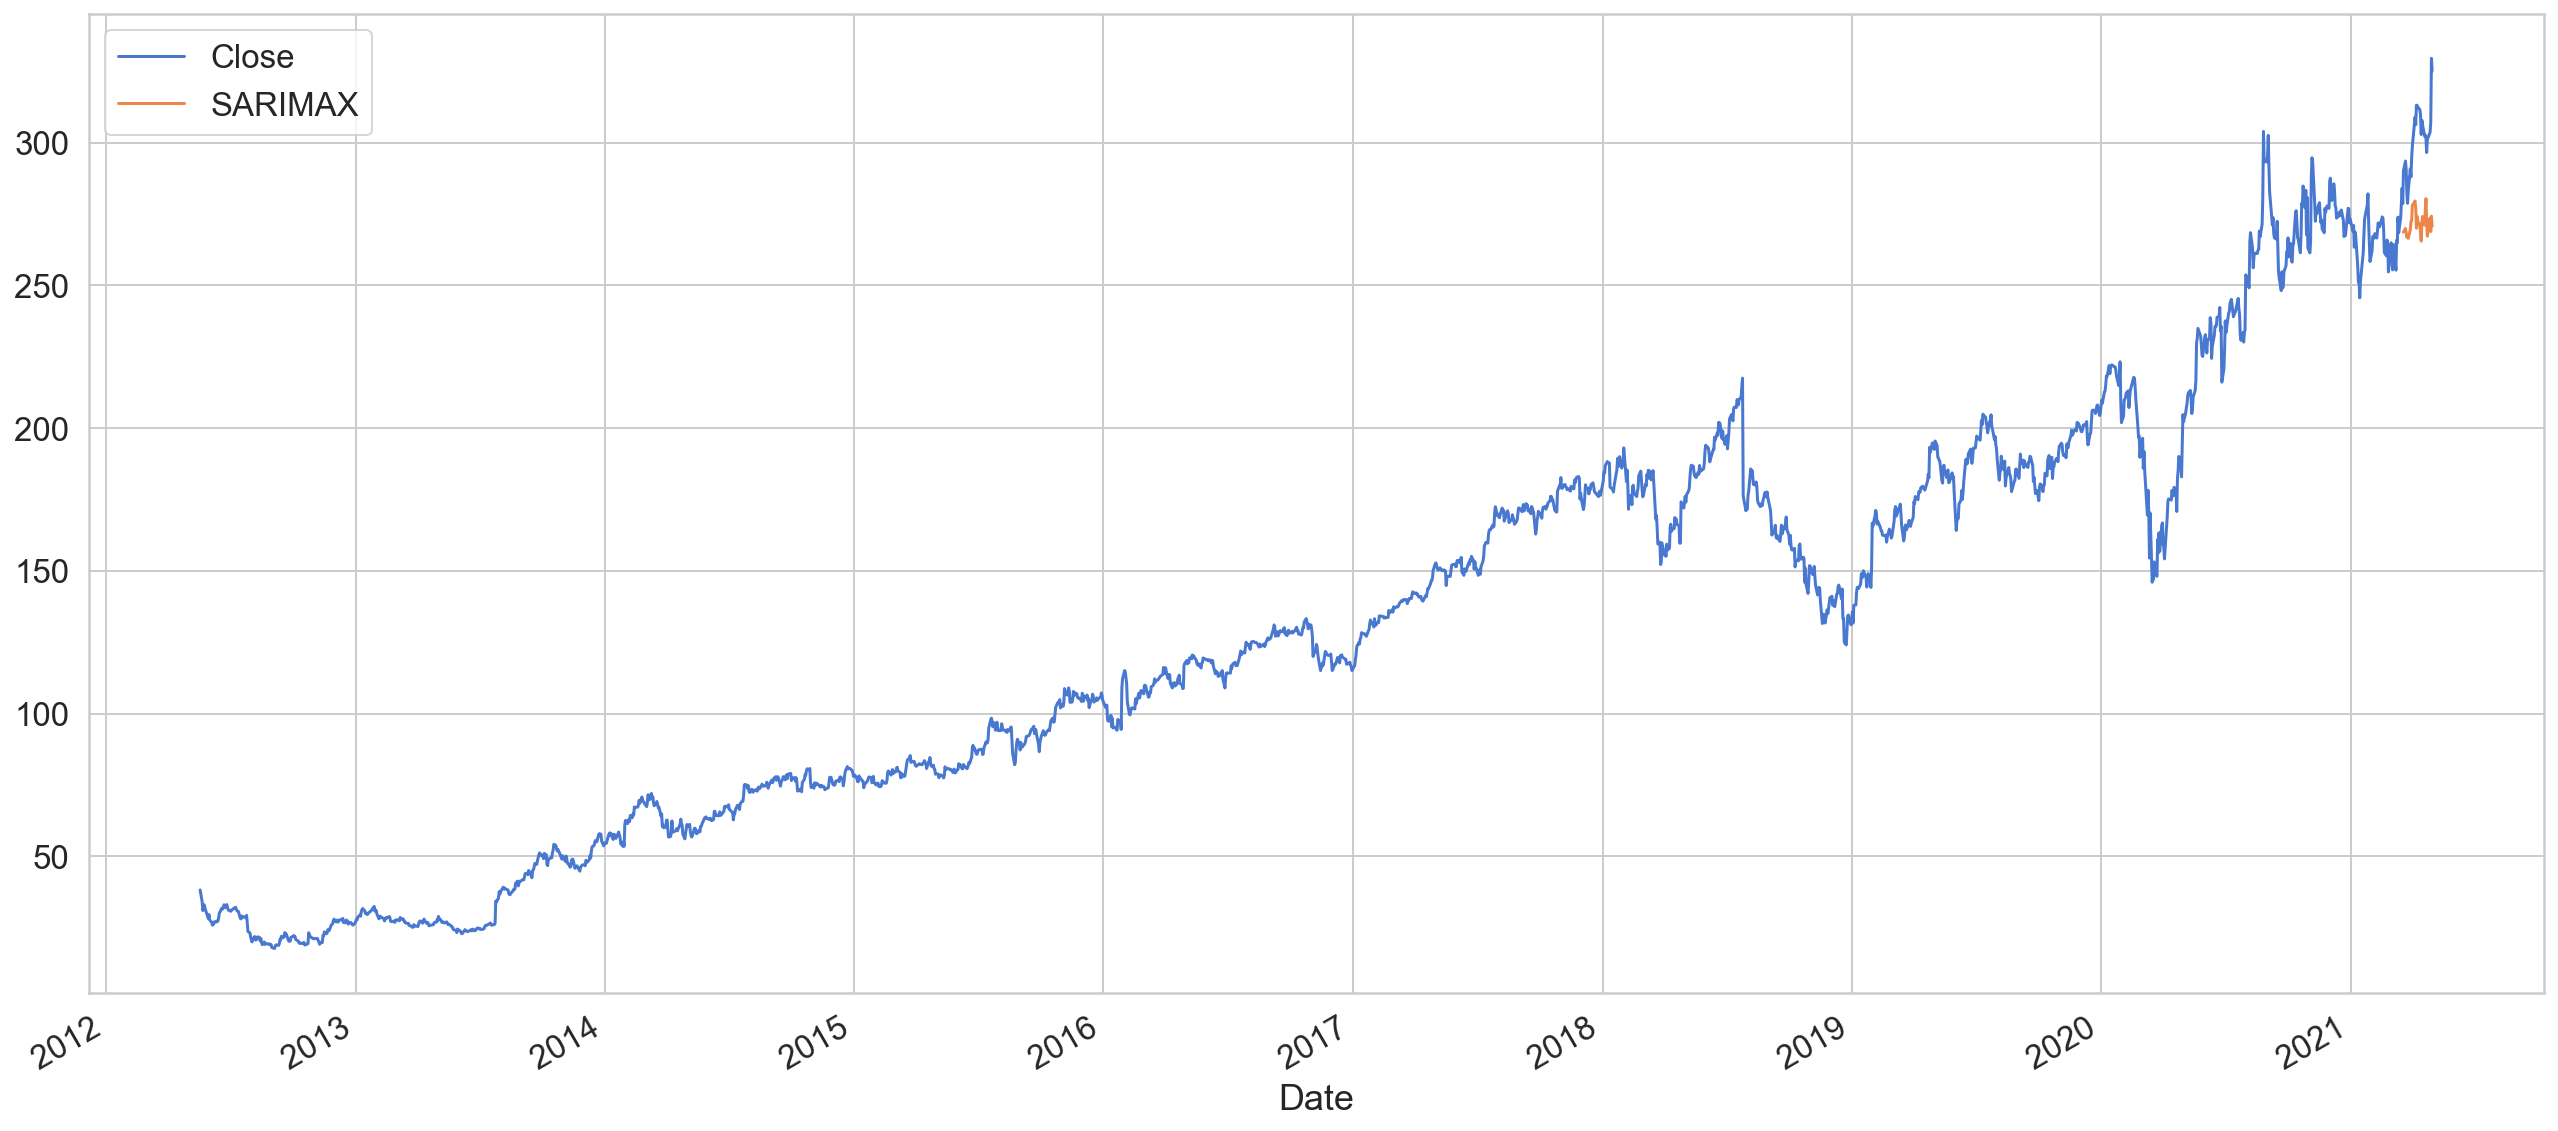

In [54]:
df['SARIMAX'] = results.predict(start=start_date,end=end_date, dynamic=True)
df[['Close','SARIMAX']].plot()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df.dropna()['Close'], df.dropna()[['SARIMAX']], squared=False)

31.997303585809654

**CONCLUSION**
- The stock price for Facebook is basically very volatile although overall it is increasingly.
- Therefore, it is very difficult to accurately forecast the future stock price.

# Hyperparameter Tuning

In [56]:
p_values = np.arange(2, 5)
d_values = np.arange(1, 4)
q_values = np.arange(26, 29)

In [57]:
from itertools import product
print(list(product(p_values, d_values, q_values)))

[(2, 1, 26), (2, 1, 27), (2, 1, 28), (2, 2, 26), (2, 2, 27), (2, 2, 28), (2, 3, 26), (2, 3, 27), (2, 3, 28), (3, 1, 26), (3, 1, 27), (3, 1, 28), (3, 2, 26), (3, 2, 27), (3, 2, 28), (3, 3, 26), (3, 3, 27), (3, 3, 28), (4, 1, 26), (4, 1, 27), (4, 1, 28), (4, 2, 26), (4, 2, 27), (4, 2, 28), (4, 3, 26), (4, 3, 27), (4, 3, 28)]


In [58]:
combos = list(product(p_values, d_values, q_values))

In [59]:
results_df = pd.DataFrame(columns=['model_type', 'p', 'd', 'q', 'AIC', 'RMSE'])

In [60]:
# from tqdm import tqdm

# res_dict = {}
# for p, d, q in tqdm(combos):
#     order = (p, d, q)
#     model = ARIMA(df['Close'], order=order)
#     fitted_model = model.fit()
#     df['Predictions'] = fitted_model.predict(start=start_date,end=end_date, dynamic=True)
    
#     res_dict['model_type'] = 'ARIMA'
#     res_dict['p'] = p
#     res_dict['d'] = d
#     res_dict['q'] = q
#     res_dict['AIC'] = fitted_model.aic
#     res_dict['RMSE'] = mean_squared_error(df.dropna()['Close'], 
#                                           df.dropna()[['Predictions']], 
#                                           squared=False)
#     results_df = results_df.append(res_dict, ignore_index=True)

In [61]:
# results_df.sort_values('AIC')

In [62]:
# results_df.sort_values('RMSE')

In [63]:
# best_aic = results_df.sort_values('AIC').iloc[0].to_dict()
# best_rmse = results_df.sort_values('RMSE').iloc[0].to_dict()
# best_aic, best_rmse

In [64]:
# order = best_rmse['p'], best_rmse['d'], best_rmse['q']
# order  # (4, 3, 27)

In [65]:
# order = best_aic['p'], best_aic['d'], best_aic['q']
# order  # (3, 1, 26)

Start date	:  2021-03-19
End date	:  2021-04-30
Forecast days	:  30

(p, d, q)	:  (3, 1, 26)


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




RMSE	=  24.55103803966795
AIC	=  11550.432196615344


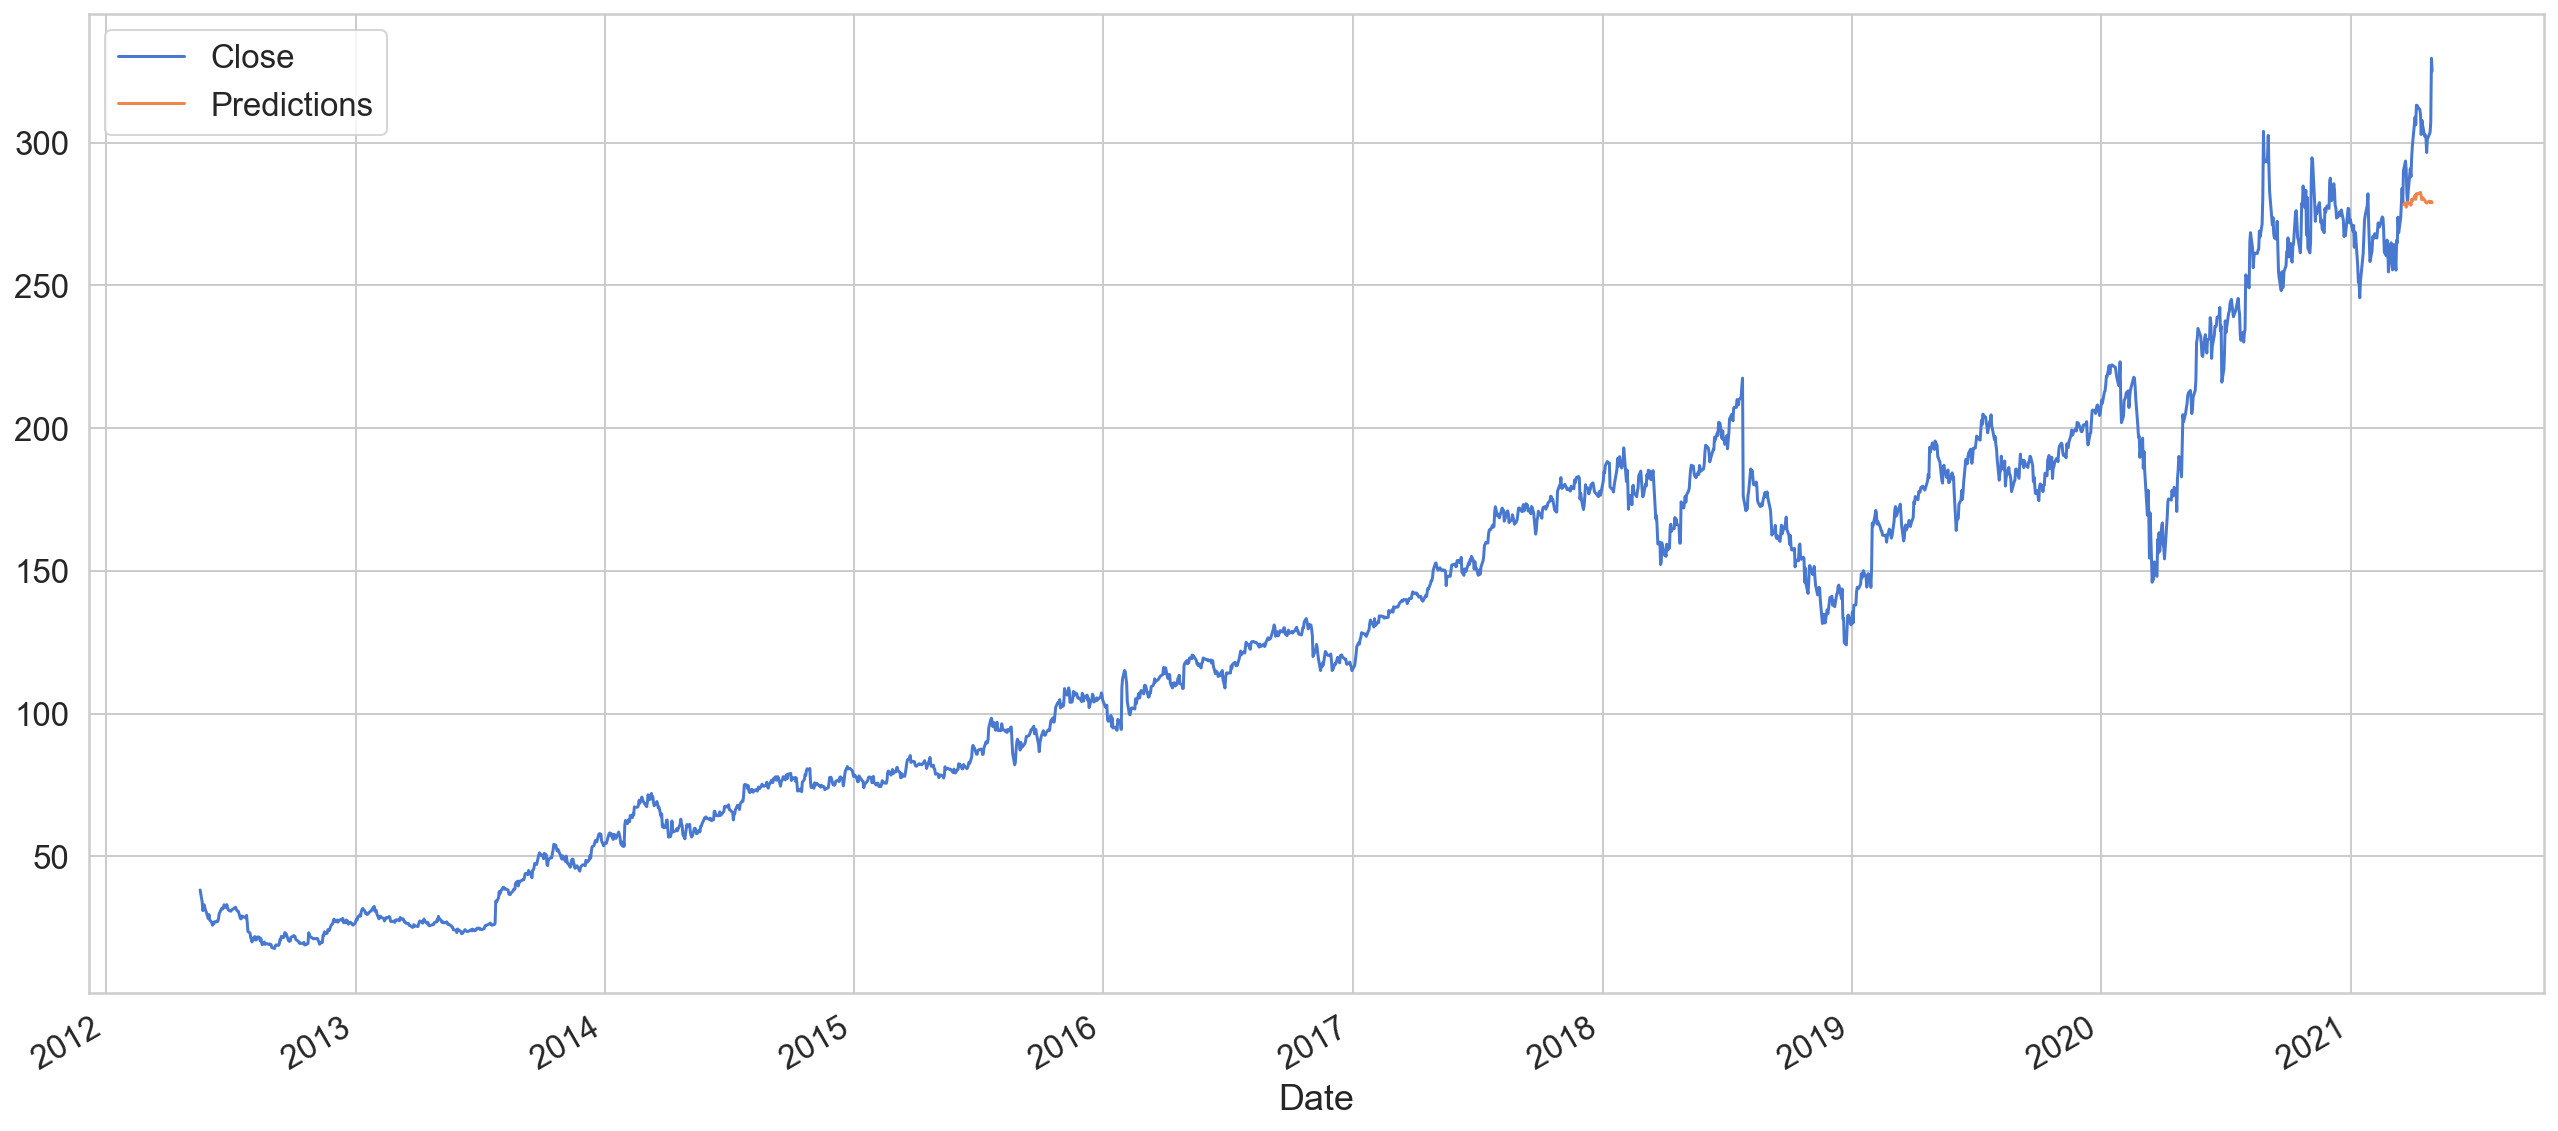

In [66]:
order = (3, 1, 26)
fitted_model = fit_predict(df, order=order, forecast_len=30)

Start date	:  2021-03-19
End date	:  2021-04-30
Forecast days	:  30

(p, d, q)	:  (4, 3, 27)


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




RMSE	=  20.373804210376665
AIC	=  11590.191347150581


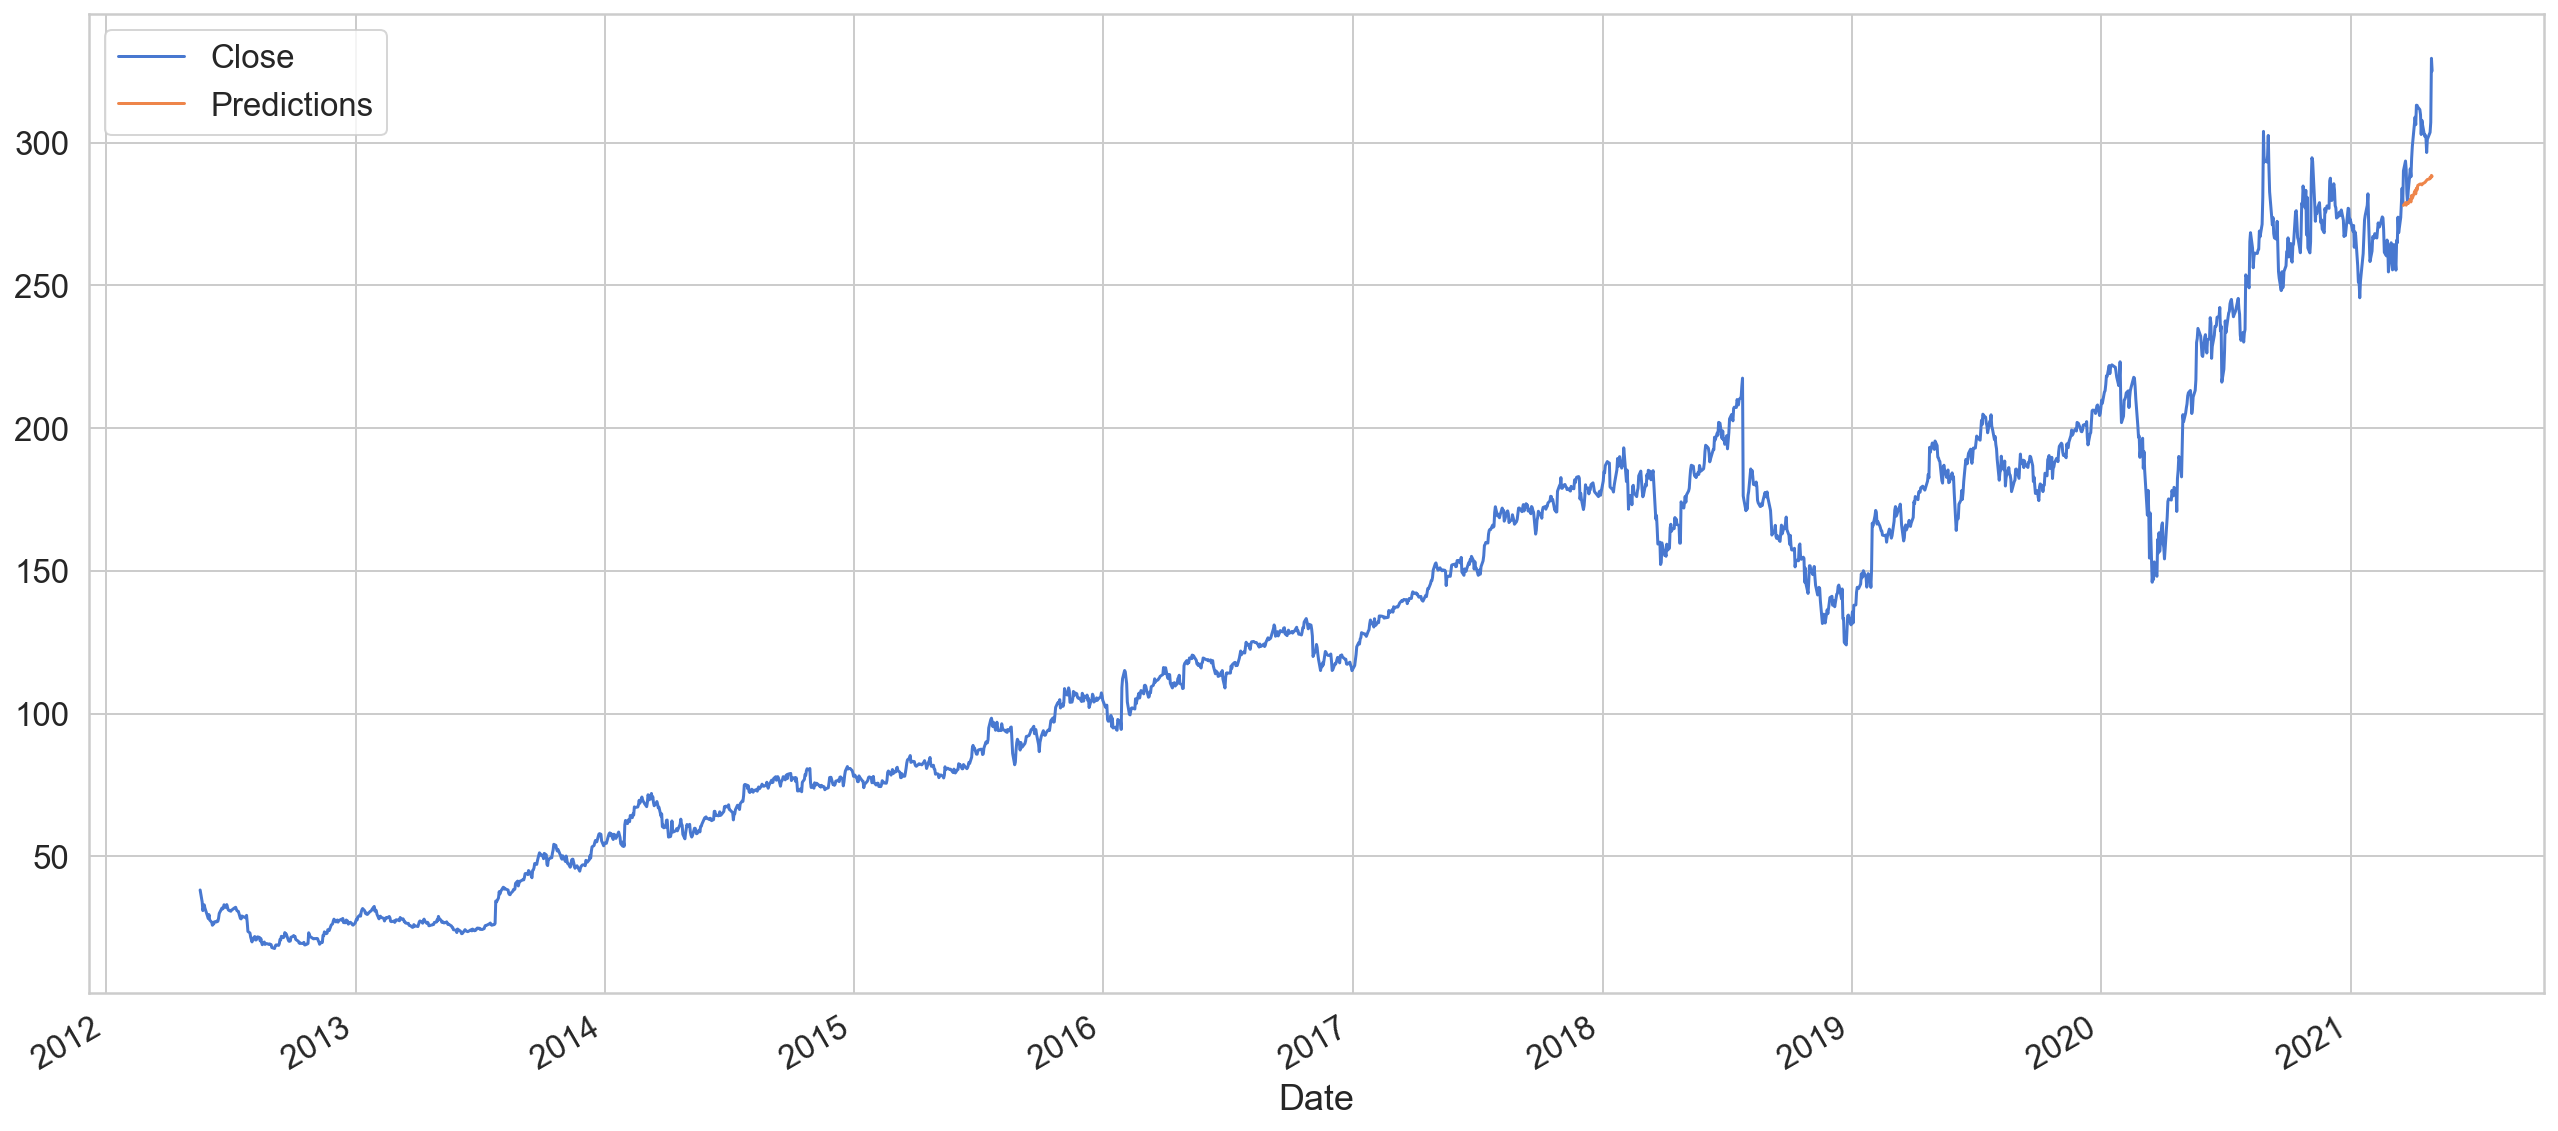

In [76]:
order = (4, 3, 27)
fitted_model, df = fit_predict(df, order=order, forecast_len=30, return_df=True)

In [79]:
df.head()

,Close,Seasonal First Difference,Predictions,SARIMAX
Date,,,,
2012-05-18,38.230000,NaN,NaN,NaN
2012-05-21,34.029999,NaN,NaN,NaN
2012-05-22,31.000000,NaN,NaN,NaN
2012-05-23,32.000000,NaN,NaN,NaN
2012-05-24,33.029999,NaN,NaN,NaN


In [78]:
forecast_df = df[['Close', 'Predictions', 'SARIMAX']].copy()
forecast_df.rename(columns={'Predictions': 'ARIMA'}, inplace=True)
forecast_df.tail()

,Close,ARIMA,SARIMAX
Date,,,
2021-04-26,303.040009,287.233024,272.106870
2021-04-27,303.570007,287.832450,273.619620
2021-04-28,307.100006,287.570311,268.851699
2021-04-29,329.510010,288.505425,274.239545
2021-04-30,325.079987,288.171662,270.749291


In [80]:
forecast_df.head()

,Close,ARIMA,SARIMAX
Date,,,
2012-05-18,38.230000,NaN,NaN
2012-05-21,34.029999,NaN,NaN
2012-05-22,31.000000,NaN,NaN
2012-05-23,32.000000,NaN,NaN
2012-05-24,33.029999,NaN,NaN


In [81]:
forecast_df.to_csv('results.csv')